## ECE 176 Final Project

In this project I will be using the Berkeley DeepDrive BDD100k dataset. I reduced the training images because the original dataset contained 70,000 images which would be too much for my computer to handle. I reduced it to 10,000 images while keeping class balance.  

In [2]:
import os
import json
import random
import shutil
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.optim as optim

### Code used to reduce 70,000 to 10,000 images

In [3]:
# # Paths to your directories
# image_dir = "bdd100k/images/train/unused_train"  # Folder with original images
# json_dir = "bdd100k/labels/train/unused_train"  # Folder with original JSON files

# # Output directories for the reduced dataset
# output_image_dir = "bdd100k/images/train/reduced_train"
# output_json_dir = "bdd100k/labels/train/reduced_train"

# num_images = 5179

# # Ensure output and unused folders exist
# for d in [output_image_dir, output_json_dir]:
#     os.makedirs(d, exist_ok=True)

# # Step 1: Get all JSON files
# json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]
# total_files = len(json_files)

# # Step 2: Randomly sample the desired number of JSON files
# selected_json_files = set(random.sample(
#     json_files, min(num_images, total_files)))
# # Adjust for .png if needed
# selected_image_files = {f.replace('.json', '.jpg')
#                         for f in selected_json_files}


# def move_file(src, dest):
#     if os.path.exists(src):
#         shutil.move(src, dest)


# # Step 3: Move selected files (reduced dataset)
# with ThreadPoolExecutor(max_workers=4) as executor:
#     for json_file in tqdm(selected_json_files, desc="Moving selected files"):
#         image_file = json_file.replace(".json", ".jpg")  # or ".png"

#         # Full paths
#         json_src = os.path.join(json_dir, json_file)
#         json_dest = os.path.join(output_json_dir, json_file)
#         image_src = os.path.join(image_dir, image_file)
#         image_dest = os.path.join(output_image_dir, image_file)

#         # Submit move jobs
#         executor.submit(move_file, json_src, json_dest)
#         executor.submit(move_file, image_src, image_dest)

# print(f"\nDataset reduced to {len(selected_json_files)} images.")


### Convert .json to YOLO format annotations

In [4]:
# # === Paths ===
# json_dir = "test"                 # Input JSON files
# output_label_dir = "bdd100k/labels/test"    # Output YOLO .txt files
# os.makedirs(output_label_dir, exist_ok=True)

# # === Image dimensions (adjust if needed) ===
# img_width = 1280
# img_height = 720

# # === YOLO Class Mapping ===
# class_mapping = {
#     "car": 0, 
#     "truck": 1, 
#     "bus": 2, 
#     "person": 3, 
#     "rider": 4, 
#     "bike": 5, 
#     "motor": 6,
#     "traffic sign": 7, 
#     "traffic light": 8
# }

# # === Main loop: convert JSON to YOLO format ===
# for json_file in os.listdir(json_dir):
#     if not json_file.endswith(".json"):
#         continue

#     with open(os.path.join(json_dir, json_file), 'r') as f:
#         data = json.load(f)

#     image_name = data["name"] + ".jpg"
#     output_txt = os.path.join(
#         output_label_dir, image_name.replace(".jpg", ".txt"))

#     with open(output_txt, 'w') as out_f:
#         for obj in data['frames'][0]['objects']:
#             if "box2d" not in obj:
#                 continue  # skip non-box2d objects

#             category = obj["category"]
#             if category not in class_mapping:
#                 continue

#             x1 = obj["box2d"]["x1"]
#             y1 = obj["box2d"]["y1"]
#             x2 = obj["box2d"]["x2"]
#             y2 = obj["box2d"]["y2"]

#             # Convert to YOLO format (normalized)
#             xc = (x1 + x2) / 2 / img_width
#             yc = (y1 + y2) / 2 / img_height
#             w = (x2 - x1) / img_width
#             h = (y2 - y1) / img_height

#             # Write to label file
#             class_id = class_mapping[category]
#             out_f.write(f"{class_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

# print("Conversion complete.")

### Example of image with corresponding bounding boxes

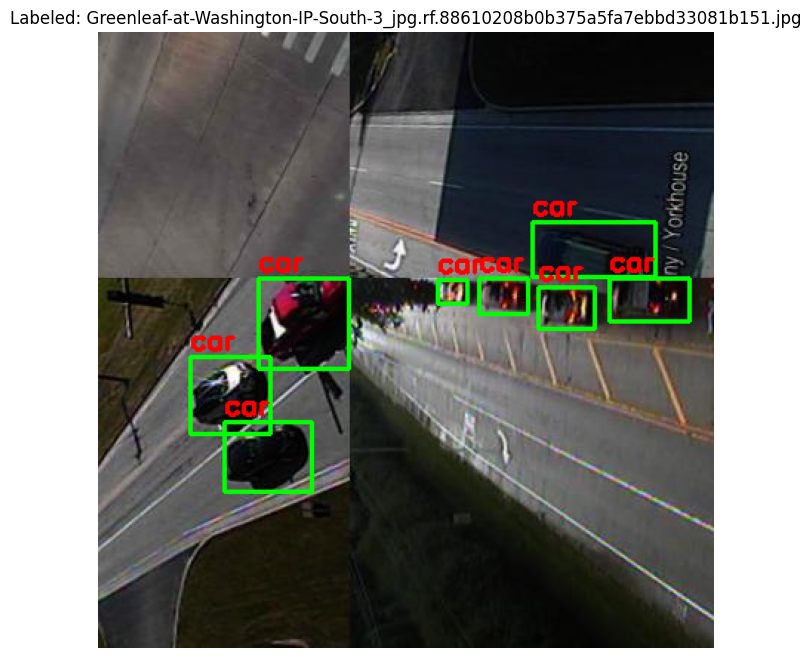

In [5]:
# image_name = "Aptakisic-at-Bond-IP-East-0_jpg.rf.2ea8b79269e6f3ce6be021e86d284f75.jpg"  # without path
image_dir = "train/images"
label_dir = "train/labels"

image_files = [f for f in os.listdir(
    image_dir) if f.endswith(".jpg") or f.endswith(".png")]
image_name = random.choice(image_files)

class_names = [
    "car",
    # "truck",
    # "bus",
    # "person",
    # "rider",
    # "bike",
    # "motor",
    # "traffic sign",
    # "traffic light"
]

image_path = os.path.join(image_dir, image_name)
label_path = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))

if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found: {image_path}")
if not os.path.exists(label_path):
    raise FileNotFoundError(f"Label not found: {label_path}")

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

with open(label_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        class_id = int(parts[0])
        x_center = float(parts[1]) * width
        y_center = float(parts[2]) * height
        box_width = float(parts[3]) * width
        box_height = float(parts[4]) * height

        x1 = int(x_center - box_width / 2)
        y1 = int(y_center - box_height / 2)
        x2 = int(x_center + box_width / 2)
        y2 = int(y_center + box_height / 2)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, class_names[class_id], (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.title(f"Labeled: {image_name}")
plt.show()

## Begin Actual Implementation

In [6]:
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_size=416, flip_prob=0.5):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.images = [img for img in os.listdir(
            image_dir) if img.endswith('.jpg') or img.endswith('.png')]
        self.flip_prob = flip_prob

        self.base_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, image_name.replace(
            ".jpg", ".txt").replace(".png", ".txt"))

        image = Image.open(image_path).convert("RGB")
        boxes = []

        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f.readlines():
                    class_id, x_center, y_center, width, height = map(
                        float, line.strip().split())
                    boxes.append([class_id, x_center, y_center, width, height])
        boxes = torch.tensor(boxes)

        flipped = False
        if torch.rand(1).item() < self.flip_prob:
            image = T.functional.hflip(image)
            flipped = True

        image = self.base_transform(image)  

        if flipped and len(boxes) > 0:
            boxes[:, 1] = 1.0 - boxes[:, 1] 

        return image, boxes

In [7]:
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    images = torch.stack(images, dim=0)
    return images, targets


class SimpleYOLO(nn.Module):
    def __init__(self, S=13, B=2, num_classes=9):
        super(SimpleYOLO, self).__init__()
        self.S = S
        self.B = B
        self.C = num_classes
        self.output_channels = B * (5 + self.C)

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1,
                      padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, stride=1,
                      padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, stride=1,
                      padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, stride=1,
                      padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, stride=1,
                      padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((S, S))
        )

        self.prediction_head = nn.Conv2d(
            256, self.output_channels, kernel_size=1)

    def forward(self, x):
        features = self.feature_extractor(x)
        predictions = self.prediction_head(features)
        return predictions.permute(0, 2, 3, 1)

In [8]:
image_dir = "train/images"
label_dir = "train/labels"

dataset = YoloDataset(image_dir=image_dir, label_dir=label_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)

images, boxes = next(iter(dataloader))
print("Image shape:", images.shape)
print("Boxes:", boxes[0])


Image shape: torch.Size([4, 3, 416, 416])
Boxes: tensor([[0.0000, 0.6238, 0.2752, 0.2716, 0.2812],
        [0.0000, 0.7320, 0.3594, 0.1418, 0.1130],
        [0.0000, 0.7704, 0.3978, 0.1755, 0.0361],
        [0.0000, 0.3029, 0.7728, 0.1418, 0.1346],
        [0.0000, 0.1815, 0.7115, 0.2284, 0.2284],
        [0.0000, 0.0409, 0.7500, 0.0817, 0.0865],
        [0.0000, 0.7236, 0.9050, 0.0938, 0.0938],
        [0.0000, 0.6430, 0.8918, 0.0769, 0.0745],
        [0.0000, 0.8606, 0.9627, 0.0817, 0.0697]])


In [9]:
class YoloLoss(nn.Module):
    def __init__(self, S=13, B=2, C=9, lambda_coord=5, lambda_noobj=0.5):
        super(YoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse = nn.MSELoss(reduction='sum')

    def forward(self, predictions, target):
        loss = self.mse(predictions, torch.zeros_like(predictions))
        return loss


In [10]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = SimpleYOLO(S=13, B=2, num_classes=9).to(device)
loss_fn = YoloLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for batch_idx, (images, targets) in enumerate(dataloader):
    images = images.to(device)
    predictions = model(images) 

    loss = loss_fn(predictions, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"[Batch {batch_idx}] Loss: {loss.item():.4f}")

    if batch_idx == 5: 
        break

[Batch 0] Loss: 35.3151
[Batch 1] Loss: 32.5089
[Batch 2] Loss: 29.8650
[Batch 3] Loss: 27.1501
[Batch 4] Loss: 24.6508
[Batch 5] Loss: 22.2008


In [11]:

def encode_target_yolo(boxes, S=13, B=1, C=9):
    target = torch.zeros((S, S, B * (5 + C)))

    for box in boxes:
        class_id, x, y, w, h = box
        class_id = int(class_id)

        i = int(x * S)
        j = int(y * S)

        if i >= S or j >= S:
            continue

        x_cell = x * S - i
        y_cell = y * S - j

        box_encoding = torch.zeros(B * (5 + C))
        box_encoding[0] = 1.0
        box_encoding[1] = x_cell
        box_encoding[2] = y_cell
        box_encoding[3] = w
        box_encoding[4] = h
        box_encoding[5 + class_id] = 1.0

        target[j, i] = box_encoding

    return target

In [12]:
class YoloLoss(nn.Module):
    def __init__(self, S=13, B=1, C=9, lambda_coord=5, lambda_noobj=0.5):
        super(YoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse = nn.MSELoss(reduction='sum')

    def forward(self, predictions, target):
        obj_mask = target[..., 0] == 1  
        noobj_mask = target[..., 0] == 0

        box_loss = self.mse(predictions[obj_mask][..., 1:5], target[obj_mask][..., 1:5])

        obj_loss = self.mse(predictions[obj_mask][..., 0], target[obj_mask][..., 0])
        noobj_loss = self.mse(predictions[noobj_mask][..., 0], target[noobj_mask][..., 0])

        class_loss = self.mse(predictions[obj_mask][..., 5:], target[obj_mask][..., 5:])

        total_loss = (
            self.lambda_coord * box_loss +
            obj_loss +
            self.lambda_noobj * noobj_loss +
            class_loss
        )

        return total_loss


In [13]:
model = SimpleYOLO(S=13, B=1, num_classes=9).to(device)
loss_fn = YoloLoss(S=13, B=1, C=9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for batch_idx, (images, box_list) in enumerate(dataloader):
    images = images.to(device)

    targets = [encode_target_yolo(box, S=13, B=1, C=9) for box in box_list]
    targets = torch.stack(targets).to(device)  

    predictions = model(images) 
    loss = loss_fn(predictions, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"[Batch {batch_idx}] Loss: {loss.item():.4f}")

    if batch_idx == 5: 
        break


[Batch 0] Loss: 214.9400
[Batch 1] Loss: 296.0431
[Batch 2] Loss: 248.8391
[Batch 3] Loss: 272.8024
[Batch 4] Loss: 290.1975
[Batch 5] Loss: 193.0224


In [14]:
from tqdm.notebook import tqdm


def train_yolo(model, dataloader, optimizer, loss_fn, device, epochs=5, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)

    model.to(device)
    model.train()
    
    best_loss = float("inf")

    for epoch in range(epochs):
        total_loss = 0
        print(f"Epoch {epoch+1}/{epochs}")
        loop = tqdm(dataloader, leave=False)

        for batch_idx, (images, box_list) in enumerate(loop):
            images = images.to(device)
            targets = [encode_target_yolo(box, S=13, B=1, C=9)
                       for box in box_list]
            targets = torch.stack(targets).to(device)

            predictions = model(images)
            loss = loss_fn(predictions, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f"Batch {batch_idx}")
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }
        torch.save(checkpoint, os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth"))

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(checkpoint, os.path.join(save_dir, "best_model.pth"))

In [ ]:
model = SimpleYOLO(S=13, B=1, num_classes=9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = YoloLoss(S=13, B=1, C=9, lambda_coord=2)
print("using device: " + device)

train_yolo(model, dataloader, optimizer, loss_fn, device, epochs=5)

In [15]:
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")
    return checkpoint['epoch']

model = SimpleYOLO(S=13, B=1, num_classes=9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

load_checkpoint(model, optimizer, "checkpoints/best_model.pth")

model.to(device)
model.eval()


Loaded checkpoint from epoch 5 with loss 35.6202


SimpleYOLO(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): AdaptiveAvgPool2d(output_size=(13, 13))
  )
  (prediction_hea

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def decode_predictions(pred, conf_thresh=0.3):
    S, B, C = 13, 1, 9
    pred = pred.squeeze(0)  
    boxes = []

    for i in range(S):
        for j in range(S):
            cell = pred[i, j]
            conf = cell[0].item()
            if conf < conf_thresh:
                continue

            x_cell, y_cell, w, h = cell[1:5]
            class_probs = cell[5:]
            class_id = torch.argmax(class_probs).item()

            x_center = (j + x_cell.item()) / S
            y_center = (i + y_cell.item()) / S

            boxes.append([x_center, y_center, w.item(), h.item(), class_id, conf])

    return boxes

def plot_predictions(image_tensor, boxes, class_names):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    h, w = img.shape[:2]

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box in boxes:
        xc, yc, bw, bh, class_id, conf = box
        x = (xc - bw/2) * w
        y = (yc - bh/2) * h
        bw *= w
        bh *= h
        rect = patches.Rectangle((x, y), bw, bh, linewidth=1, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y - 5, f"{class_names[class_id]}", color="white", backgroundcolor="none", fontsize=8)

    plt.axis("off")
    plt.show()


In [22]:
import random
from PIL import Image

def visualize_random_test_image(model, test_image_dir, class_names, device="mps", S=13, conf_thresh=0.5):
    image_files = [f for f in os.listdir(test_image_dir) if f.endswith(".jpg") or f.endswith(".png")]
    random_img_name = random.choice(image_files)
    img_path = os.path.join(test_image_dir, random_img_name)

    transform = T.Compose([
        T.Resize((416, 416)),
        T.ToTensor(),
    ])
    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor).cpu()

    decoded_boxes = decode_predictions(output, conf_thresh=conf_thresh)

    plot_predictions(image_tensor.squeeze(0), decoded_boxes, class_names)

    print(f"Predictions for: {random_img_name}")


In [18]:
import random

def decode_predictions(pred, conf_thresh=0.3, S=13, B=1, C=9):
    pred = pred.squeeze(0)  
    boxes = []

    for i in range(S):
        for j in range(S):
            cell = pred[i, j]
            conf = cell[0].item()
            if conf < conf_thresh:
                continue

            x_cell, y_cell, w, h = cell[1:5]
            class_probs = cell[5:]
            class_id = torch.argmax(class_probs).item()

            x_center = (j + x_cell.item()) / S
            y_center = (i + y_cell.item()) / S

            boxes.append([x_center, y_center, w.item(), h.item(), class_id, conf])

    return boxes

def plot_boxes_on_image(image_tensor, boxes, class_names, show_conf=False, title=""):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    h, w = img.shape[:2]

    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.set_title(title)

    for box in boxes:
        xc, yc, bw, bh, class_id, *rest = box
        x = (xc - bw/2) * w
        y = (yc - bh/2) * h
        bw *= w
        bh *= h

        label = f"{class_names[int(class_id)]}"
        if show_conf and rest:
            label += f" ({rest[0]:.2f})"

        rect = patches.Rectangle((x, y), bw, bh, linewidth=2, edgecolor="lime" if show_conf else "orange", facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y - 5, label, color="lime", backgroundcolor="none", fontsize=8)

    plt.axis("off")
    plt.show()


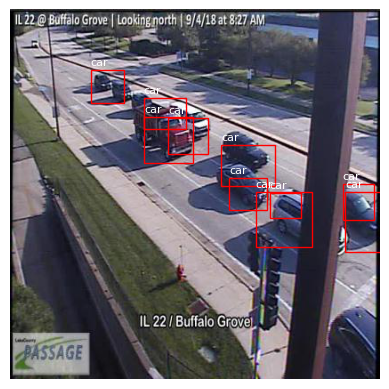

Predictions for: IL-22-at-Buffalo-Grove-North-1_jpg.rf.8825e49ab7190e5a0419d462de59cae2.jpg


In [23]:
test_image_dir = "test/images"  
class_names = ["car",
            #    "truck",
            #    "bus",
            #    "person",
            #    "rider",
            #    "bike",
            #    "motor",
            #    "traffic sign",
            #    "traffic light"
               ]

visualize_random_test_image(model, test_image_dir, class_names, device=device)

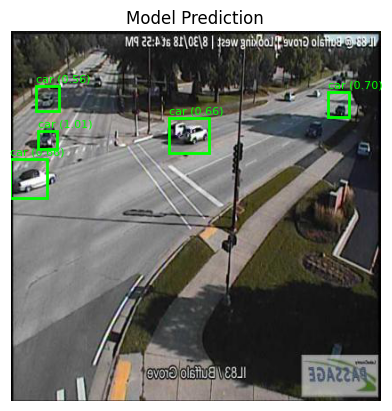

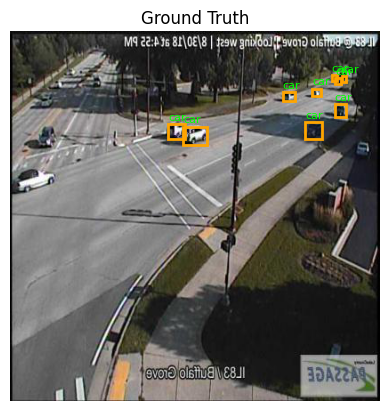

In [21]:
val_image_dir = "valid/images"
val_label_dir = "valid/labels"
val_dataset = YoloDataset(image_dir=val_image_dir, label_dir=val_label_dir)
class_names = ["car",
            #    "truck",
            #    "bus",
            #    "person",
            #    "rider",
            #    "bike",
            #    "motor",
            #    "traffic sign",
            #    "traffic light"
               ]

idx = random.randint(0, len(val_dataset) - 1)
img_tensor, gt_boxes = val_dataset[idx]

model.eval()
input_tensor = img_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(input_tensor).cpu()

decoded_preds = decode_predictions(prediction, conf_thresh=0.5)

gt_box_list = [[x[1], x[2], x[3], x[4], x[0]] for x in gt_boxes]

plot_boxes_on_image(img_tensor, decoded_preds, class_names,
                    show_conf=True, title="Model Prediction")

plot_boxes_on_image(img_tensor, gt_box_list, class_names,
                    show_conf=False, title="Ground Truth")